In [ ]:
##conda install -c -conda-forge fbprophet <-- w konsoli anaconda, potem plotly==3.10.0

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fbprophet import Prophet

from sklearn.metrics import mean_absolute_error as mae

%matplotlib inline

In [2]:
def normal_equation(X,y):
    X_b = np.c_[np.ones((len(X),1)),X]
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    
    return theta_best

In [3]:
def linear_func(X, alfa = None, beta = 0.0):
    if alfa is None:
        mean_value = np.mean(X)
        return [mean_value] * len(X)
    
    X_new = np.linspace(X.min(),X.max(),len(y))
    X_new_b = np.c_[np.ones((len(y),1)), X_new]
        
    return [alfa*x + beta for _, x in X_new_b]

In [4]:
def norm_equation_linear_func(X,y):
    X_new = np.linspace(X.min(),X.max(),len(y))
    X_new_b = np.c_[np.ones((len(y),1)), X_new]
    y_predict = X_new_b.dot(normal_equation(X,y))
    
    return y_predict

In [5]:
path = 'https://raw.githubusercontent.com/dataworkshop/5dwchallenge_2019/master/challenge5/input/mauna_loa.csv'

In [6]:
df = pd.read_csv(path)

In [7]:
df['ppm_fixed'] = df.ppm.map(lambda x: None if x < 0  else x).fillna(method='backfill')
df['date'] = pd.to_datetime(df.apply(lambda row: '{}-{}-{}'.format(int(row.year), int(row.month), int(row.day)) , axis = 1))

In [8]:
X = df.index
y = df.ppm_fixed

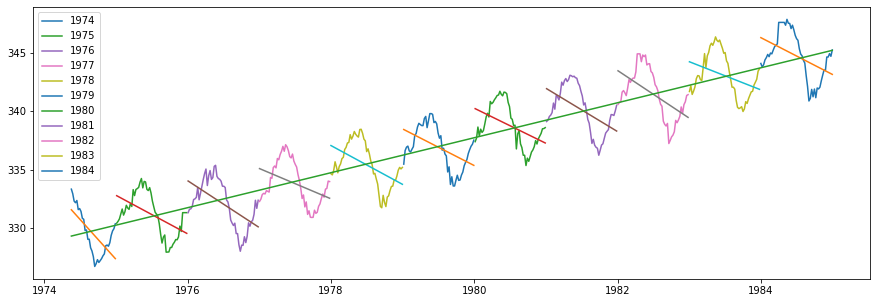

In [9]:
#idx = np.linspace(X.min(),X.max(),len(X))
plt.figure(figsize=(15,5))
year_min = 1974
year_max = 1985
for year in range(year_min, year_max):
    df_year = df[df.year == year]
    plt.plot(df_year.date, df_year.ppm_fixed, label=year)
    plt.plot(df_year.date, norm_equation_linear_func(df_year.index, df_year.ppm_fixed))

df_year = df[np.logical_and(df.year >= year_min, df.year < year_max)]
plt.plot(df_year.date, norm_equation_linear_func(df_year.index, df_year.ppm_fixed))    

plt.legend();

## Prophet

In [143]:
cut_year = 2010
train = df[df.year <= cut_year]
test = df[df.year > cut_year]

#plt.plot(train.date, train.ppm_fixed, label='train')
#plt.plot(test.date, test.ppm_fixed, label='test')

#plt.legend();

In [144]:
fb_df = train[['date', 'ppm_fixed']].copy()
fb_df.columns = ['ds','y']
#fb_df.head()

In [145]:
m = Prophet()
m.fit(fb_df);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Adrian\Anaconda3\envs\challange5day\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [146]:
future = m.make_future_dataframe(periods=len(test), freq='W', include_history=False)
forecast = m.predict(future)

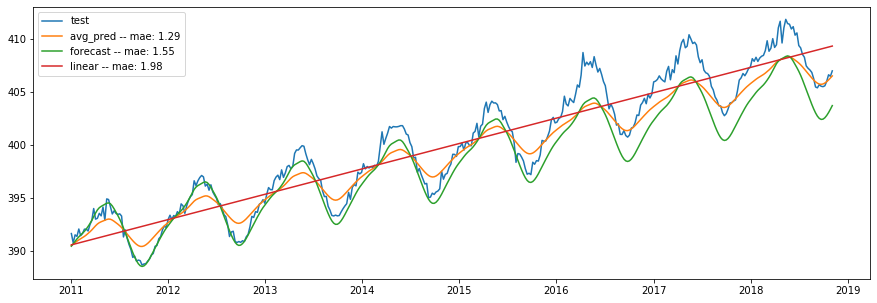

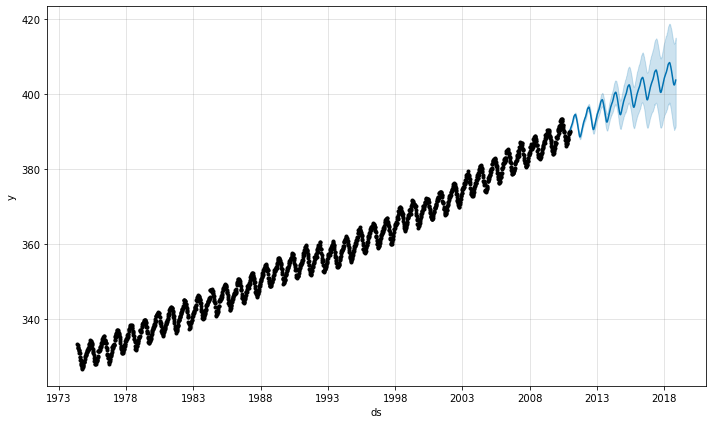

In [152]:
avg_pred = [np.sqrt(x*y) for x,y  in zip(forecast.yhat,norm_equation_linear_func(test.index, test.ppm_fixed))]

plt.figure(figsize=(15,5))

#plt.plot(train.date, train.ppm_fixed, label='train')
plt.plot(test.date, test.ppm_fixed, label='test')
plt.plot(test.date, avg_pred, label=f'avg_pred -- mae: {np.round(mae(avg_pred, test.ppm_fixed),2)}')
plt.plot(test.date, forecast.yhat, label=f'forecast -- mae: {np.round(mae(forecast.yhat, test.ppm_fixed),2)}')
plt.plot(test.date, norm_equation_linear_func(test.index, test.ppm_fixed), label=f'linear -- mae: {np.round(mae(norm_equation_linear_func(test.index, test.ppm_fixed), test.ppm_fixed),2)}')

plt.legend();
m.plot(forecast);